In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import log
import seaborn as sb

In [2]:
def relDiff(c1, c2, DF, cutoff=0.01, verbose=False):
    import pandas as pd
    """
    Computes the relative difference between the values
    in columns c1 and c2 of DF.
    c1 and c2 are column names and DF is a Pandas data frame.
    Values less than cutoff will be treated as 0.
    The relative difference is defined as
    d(x_i, y_i) =
        0.0 if x_i and y_i are 0
        (x_i - y_i) / (|x_i + y_i|) otherwise
    This function returns two values.
    rd is a DataFrame where the "relDiff" column contains all
    of the computed relative differences.
    nz is a set of indexes into rd for data points where
    x_i and y_i were not *both* zero.
    """
    import numpy as np
    rd = pd.DataFrame(data = {"Name" : DF.index, "relDiff" : np.zeros(len(DF.index))*np.nan})
    rd.set_index("Name", inplace=True)
    bothZero = DF.loc[(DF[c1] < cutoff) & (DF[c2] < cutoff)].index
    nonZero = DF.index.difference(bothZero)
    if (verbose):
        print("Zero occurs in both columns {} times".format(len(rd.loc[bothZero])))
        print("Nonzero occurs in at least 1 column {} times".format(len(rd.loc[nonZero])))
    allRD = 2.0 * ((DF[c1] - DF[c2]) / (DF[c1] + DF[c2]).abs())
    assert(len(rd.loc[nonZero]["relDiff"]) == len(allRD[nonZero]))
    rd["relDiff"][nonZero] = allRD[nonZero]
    if len(bothZero) > 0:
        rd["relDiff"][bothZero] = 0.0
    return rd, nonZero

In [192]:
def aggregate(df, taxidID, cntID, level = 'species'):
    agg = {}
    notFoundCntr = 0
    for idx, row in df.iterrows():
        taxid = row[taxidID]
        cnt = row[cntID]
        taxlevel = partyp[taxid][1]
        while taxlevel != level and taxid != 1:
            if taxid in partyp:    
                taxid = partyp[taxid][0]
                taxlevel = partyp[taxid][1]
            else:
                notFoundCntr+=1
                break
        if taxlevel == level:
            if taxid not in agg:
                 agg[taxid] = 0
            agg[taxid] += cnt
    print('notFound: {}'.format(notFoundCntr))
    agg_df = pd.DataFrame.from_dict(agg, orient='index').reset_index()
    agg_df.columns = ['taxid', 'count']
    return agg_df

In [144]:
# around 40,000 taxids are duplicates!!!!
partyp = {}
repeated_ids = []
with open('/mnt/scratch2/cedar/input_files/nodes.dmp') as f:
    for line in f:
        sp = line.split("|")
        if int(sp[0].strip()) in partyp:
            repeated_ids += [int(sp[0].strip())]
        else:
            partyp[int(sp[0].strip())] = [int(sp[1].strip()), sp[2].strip()]

In [365]:
# seq2taxid=pd.read_table('/mnt/scratch2/cedar/input_files/seqid2taxid.map', header=None, names=['ref', 'taxid'])
# seq2taxid['acc'] = seq2taxid['ref'].str.split('|').str[0]
# truth=pd.read_table('/mnt/scratch2/cedar/input_files/i100_ref.truth')
puff=pd.read_table('/mnt/scratch2/cedar/results/puff/aligned_trimmed_i100_31_sr1.quant/quant.sf')
# sal=pd.read_table('/mnt/scratch2/cedar/results/salmon/aligned_trimmed_i100_31_sr1.salmon/quant.sf')
# cedar=pd.read_table('/mnt/scratch2/cedar/results/cedar/aligned_trimmed_i100_31_sr1.cedar')

In [275]:
bracken=pd.read_table('/mnt/scratch2/cedar/results/bracken/trimmed_i100_k31_bracken.kreport', header=None)
bracken.columns = ['percentage', 'count', 'distinctCount', 'level', 'taxid', 'taxname']
bracken = bracken[bracken['level'] == 'S'][['taxid', 'taxname', 'count']]
bracken['taxname'] = bracken['taxname'].str.strip()

In [366]:
print(puff['NumReads'].sum())
print(sal['NumReads'].sum())
print(cedar['count'].sum())
print(bracken['count'].sum())

26043627.415000003
25836628.312000003
26065555.429669715
26321839


In [367]:
# truth_taxid = pd.merge(truth, seq2taxid, left_on='id', right_on='acc', how='left')
puff_taxid = pd.merge(puff, seq2taxid, left_on='Name', right_on='ref', how='left')
# sal_taxid = pd.merge(sal, seq2taxid, left_on='Name', right_on='ref', how='left')

In [368]:
# truth_agg = aggregate(truth_taxid, 'taxid', 'cnt')
# sal_agg = aggregate(sal_taxid, 'taxid', 'NumReads')
puff_agg = aggregate(puff_taxid, 'taxid', 'NumReads')
#cedar_agg = aggregate(cedar, 'taxaId', 'count')

notFound: 0


In [369]:
# Merging truth with prediction
trusal = pd.merge(truth_agg, sal_agg, on = 'taxid', how='outer', suffixes=['', '_sal']).fillna(0)
trusalpuf = pd.merge(trusal, puff_agg, on = 'taxid', how='outer', suffixes=['', '_puff']).fillna(0)
trusalpufced = pd.merge(trusalpuf, cedar_agg, on = 'taxid', how='outer', suffixes=['', '_cedar']).fillna(0)
trusalpufcedbrac = pd.merge(trusalpufced, bracken, on = 'taxid', how='outer', suffixes=['', '_brac']).fillna(0)

In [370]:
trusalpufcedbrac[['count', 'count_sal', 'count_puff', 'count_cedar', 'count_brac']].sum().astype(np.uint64)

count          26667004
count_sal      25836628
count_puff     26043627
count_cedar    26065555
count_brac     26321839
dtype: uint64

In [375]:
print('number of distinct species:')
minCnt = 0
for col in ['count_sal', 'count_puff', 'count_cedar', 'count_brac']:
    print('{} ==> # of unique species: {}'.format(col, len(trusalpufcedbrac[trusalpufcedbrac[col] > minCnt])))
    print('\tcorr: {}'.format(trusalpufcedbrac[(trusalpufcedbrac[col] > minCnt) | (trusalpufcedbrac['count'] != 0)]
                              [['count', col]].corr(method='spearman')['count'][col]))
    rd, _ = relDiff('count', col, trusalpufcedbrac, cutoff=minCnt)
    print("\tMARD : {}".format((0.5*rd['relDiff'].abs()).mean()))

number of distinct species:
count_sal ==> # of unique species: 628
	corr: 0.5946251965979771
	MARD : 0.8670192982780448
count_puff ==> # of unique species: 655
	corr: 0.5839174500041414
	MARD : 0.8719365202667791
count_cedar ==> # of unique species: 557
	corr: 0.6256188538182845
	MARD : 0.8494135037678909
count_brac ==> # of unique species: 623
	corr: 0.5827626569180799
	MARD : 0.8673333280273844


In [300]:
kraken=pd.read_table('/mnt/scratch2/cedar/results/bracken/i100_31.kraken', header=None)
kraken.columns = ['status', 'read', 'taxid', 'tmp', 'tmp2']
kraken = kraken[kraken['status'] == 'C'][['read', 'taxid']]
kraken['count'] = 1
kraken = kraken[['taxid', 'count']].groupby('taxid').sum().reset_index()
print(kraken['count'].sum())

247012


In [193]:
kraken_agg = aggregate(kraken, 'taxid', 'count')

notFound: 0


In [196]:
trukrak = pd.merge(truth_agg, kraken_agg, on = 'taxid', how='outer', suffixes=['', '_krak']).fillna(0)
col = 'count_krak'
print('{} ==> # of unique species: {}'.format(col, len(trukrak[trukrak[col] != 0])))
print('\tcorr: {}'.format(trukrak[(trukrak[col] != 0) | (trukrak['count'] != 0)]
                          [['count', col]].corr(method='spearman')['count'][col]))
rd, _ = relDiff('count', col, trukrak, cutoff=2)
print("\tMARD : {}".format((0.5*rd['relDiff'].abs()).mean()))

count_krak ==> # of unique species: 189
	corr: 0.9273881782943014
	MARD : 0.6429138449054718


In [235]:
col = 'count_brac'
a = trusalpufcedbrac[(trusalpufcedbrac['count'] != 0) | (trusalpufcedbrac[col] != 0)][['taxid','count',col]]
a.sort_values(by='count', ascending=False, inplace=True)
a=a.reset_index()[['taxid','count', col]]

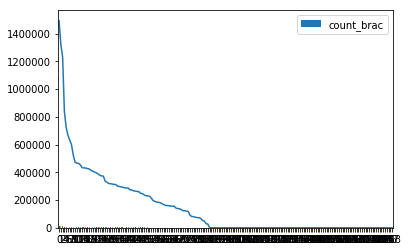

In [236]:
a.plot(kind='bar', y=col)
a['count'].plot()

In [234]:
trukrak['count_krak'].sum()

228964

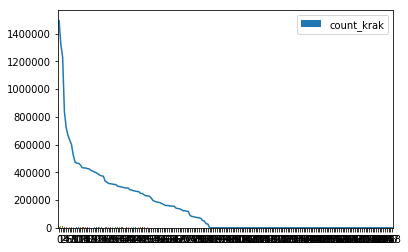

In [232]:
trukrak.sort_values(by='count', ascending=False, inplace=True)
b=trukrak.reset_index()[['taxid','count', 'count_krak']]
b.plot(kind='bar', y='count_krak')
b['count'].plot()

In [3]:
truth=pd.read_table('/mnt/scratch2/cedar/input_files/i100_taxonomy.truth')
truth = truth.groupby('Species').sum().reset_index()
print(truth.head(1))
puff=pd.read_table('/mnt/scratch2/cedar/results/script_results/noalnmnt_i100_31_sr1_puff/out.tab')
puff = puff.groupby('Species').sum().reset_index()
print(puff.head(1))
salmon=pd.read_table('/mnt/scratch2/cedar/results/script_results/i100_31_sr1_salmon/out.tab')
salmon = salmon.groupby('Species').sum().reset_index()
print(salmon.head(1))
cedar=pd.read_table('/mnt/scratch2/cedar/results/script_results/i100_31_sr1_cedar/out.tab')
cedar = cedar.groupby('Species').sum().reset_index()
print(cedar.head(1))

                   Species    TaxID  NumCounts
0  Acinetobacter baumannii  1018343   262164.0
             Species   TaxID  NumCounts
0  Absiella dolichum  428127      1.274
             Species   TaxID  NumCounts
0  Absiella dolichum  428127      1.005
             Species  TaxID  NumCounts
0  Absiella dolichum  31971      662.0


In [152]:
bracken=pd.read_table('/mnt/scratch2/cedar/results/bracken/i100_31.kreport_bracken', header=None)
bracken.columns = ['percentage', 'aggrCount', 'NumCounts', 'level', 'taxid', 'taxname']
bracken.head(1)
bracken = bracken[bracken['level'] == 'S'][['taxid', 'taxname', 'NumCounts']]
bracken['taxname'] = bracken['taxname'].str.strip()
bracken.columns = ['taxid', 'taxname', 'count']

In [149]:
truth=pd.read_table('/mnt/scratch2/cedar/input_files/i100_taxonomy.truth')
truth = truth.groupby('Species').sum().reset_index()


In [161]:
res = pd.merge(truth, bracken, left_on='Species', right_on='taxname', how='outer').fillna(0)

In [163]:
print('{} ==> # of unique species: {}'.format('bracken', len(res[res['Species'] != 0]['Species'].unique())))
print('\tcorr: {}'.format(res[['NumCounts', 'count']].corr(method='spearman')['NumCounts']['count']))
rd, _ = relDiff('NumCounts', 'count', res, cutoff=2)
print("\tMARD : {}".format((0.5*rd['relDiff'].abs()).mean()))

bracken ==> # of unique species: 85
	corr: 0.8808748841859805
	MARD : 0.6445672673488408


In [5]:
al=pd.merge(truth, puff, on='Species', how='outer')[['Species', 'NumCounts_x', 'NumCounts_y']].fillna(0)
al.columns = ['Species', 'truth', 'puff']
al=pd.merge(al, salmon, on='Species', how='outer')[['Species', 'truth', 'puff', 'NumCounts']].fillna(0)
al.columns = ['Species', 'truth', 'puff', 'salmon']
al=pd.merge(al, cedar, on='Species', how='outer')[['Species', 'truth', 'puff', 'salmon', 'NumCounts']].fillna(0)
al.columns = ['Species', 'truth', 'puff', 'salmon', 'cedar']
al=pd.merge(al, bracken, on='Species', how='outer')[['Species', 'truth', 'puff', 'salmon', 'cedar', 'NumCounts']].fillna(0)
al.columns = ['Species', 'truth', 'puff', 'salmon', 'cedar', 'bracken']

In [252]:
#26667004
pd.set_option('display.width', 500)
al[['truth', 'puff', 'salmon', 'cedar', 'bracken']].sum().astype(np.uint64)

truth      26667004
puff       26206795
salmon     25893411
cedar      26336914
bracken      246970
dtype: uint64

In [7]:
print('number of distinct species:')
for col in ['puff', 'salmon', 'cedar', 'bracken']:
    print('{} ==> # of unique species: {}'.format(col, len(al[al[col] != 0]['Species'].unique())))
    print('\tcorr: {}'.format(al[al[col] != 0][['truth', col]].corr(method='spearman')['truth'][col]))
    rd, _ = relDiff('truth', col, al, cutoff=2)
    print("\tMARD : {}".format((0.5*rd['relDiff'].abs()).mean()))

number of distinct species:
puff ==> # of unique species: 673
	corr: 0.5771148730419895
	MARD : 0.44326697994503655
salmon ==> # of unique species: 485
	corr: 0.6627743789409638
	MARD : 0.3759827143824895
cedar ==> # of unique species: 750
	corr: 0.5363935842728118
	MARD : 0.9442527780267141
bracken ==> # of unique species: 188
	corr: 0.9220709392084507
	MARD : 0.16307294380330192


In [22]:
al[al['salmon'] != 0]

,Species,truth,puff,salmon,cedar,bracken
0,Acinetobacter baumannii,262164.0,59875.158,243181.077,938622.0,2395.0
1,Alkalilimnicola ehrlichii,230160.0,52339.024,224504.034,56202.0,2234.0
2,Alkaliphilus metalliredigens,374667.0,85591.446,352826.229,109518.0,3465.0
3,Bacillus anthracis,408054.0,61818.911,394338.602,311929.0,3684.0
4,Bacillus cereus,1320777.0,248185.262,1271628.751,823304.0,12241.0
5,Bacillus clausii,286614.0,64841.676,280708.654,78647.0,2651.0
6,Bacillus halodurans,274294.0,63007.950,263758.940,93128.0,2512.0
7,Bacillus subtilis,272560.0,62709.799,265348.603,84908.0,2543.0
8,Bacillus thuringiensis,372187.0,161021.430,356551.975,374846.0,3272.0
9,Bacteroides thetaiotaomicron,402214.0,89738.833,384015.731,94806.0,3641.0


In [8]:
print('number of distinct shared species with truth:')
for col in ['puff', 'salmon', 'cedar', 'bracken']:
    print('{}: {}'.format(col, len(al[(al['truth'] != 0) & (al[col] != 0)]['Species'].unique())))

number of distinct shared species with truth:
puff: 85
salmon: 85
cedar: 85
bracken: 0


In [4]:
pufmap=pd.read_csv('/home/mohsen/pufferfish-test/out', sep='\t', header=None)
pufmap.columns = ['origread', 'puf']
pufmap['read'] = pufmap['origread'].str.split(';').str[0].str.split('/').str[1]

In [ ]:
salmap=pd.read_csv('/mnt/scratch4/mohsen/puffalign_test/out', sep='\t', header=None)
salmap.columns = ['origread', 'sal']
salmap['read'] = salmap['origread'].str.split(';').str[0].str.split('/').str[1]

In [ ]:
print(len(salmap))
print(len(pufmap))

In [ ]:
salmap.head(1)

In [58]:
print('Puff average hits over read: {}'.format(pufmap.groupby('read')['puf'].count().mean()))
print('Puff average hits over read and ref: {}'.format(pufmap.groupby(['read', 'puf'])['puf'].count().mean()))
print('Sal average hits over read: {}'.format(salmap.groupby('read')['sal'].count().mean()))
print('Sal average hits over read and ref: {}'.format(salmap.groupby(['read', 'sal'])['sal'].count().mean()))

Puff average hits over read: 1535.147682745575
Puff average hits over read and ref: 169.01331248918123
Sal average hits over read: 1524.5548226218552
Sal average hits over read and ref: 168.46238910425558


In [74]:
pufmap['count'] = 1
puf_uniqreadref = (pufmap.groupby(['read', 'puf'])['count'].count()).reset_index()
salmap['count'] = 1
sal_uniqreadref = (salmap.groupby(['read', 'sal'])['count'].count()).reset_index()

In [75]:
merged = pd.merge(sal_uniqreadref, puf_uniqreadref, left_on=['read', 'sal'], right_on=['read', 'puf'], how = 'outer').fillna(0)

In [76]:
len(merged)

740800

In [91]:
pufbetter=merged[(merged['count_x'] == 0) & (merged['read'] == merged['puf'])]
salbetter=merged[(merged['count_y'] == 0) & (merged['read'] == merged['sal'])]
pufworse=merged[(merged['count_x'] == 0) & (merged['read'] != merged['puf'])]
salworse=merged[(merged['count_y'] == 0) & (merged['read'] != merged['sal'])]

In [95]:
print('# of references found by puf but not sal: {}'.format(len(pufbetter)))
print('# of references found by sal but not puf: {}'.format(len(salbetter)))
print('# of invalid references found by puf but not sal: {}'.format(len(pufworse)))
print('# of invalid references found by sal but not puf: {}'.format(len(salworse)))
print('sum of valid hits found by puf but not sal: {}'.format(pufbetter['count_y'].sum()))
print('sum of invalid hits found by puf but not sal: {}'.format(pufworse['count_y'].sum()))
print('sum of valid hits found by sal but not puf: {}'.format(salbetter['count_x'].sum()))
print('sum of invalid hits found by sal but not puf: {}'.format(salworse['count_x'].sum()))

# of references found by puf but not sal: 164
# of references found by sal but not puf: 0
# of invalid references found by puf but not sal: 3908
# of invalid references found by sal but not puf: 1344
sum of valid hits found by puf but not sal: 52565.0
sum of invalid hits found by puf but not sal: 265940.0
sum of valid hits found by sal but not puf: 0
sum of invalid hits found by sal but not puf: 3677.0
